In [41]:
pip install xarray netCDF4 h5netcdf geopandas matplotlib folium ffmpeg

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=85c65d7119165548a15fa6ce2ce301ea108b9785c09c709efa038bc29400eda5
  Stored in directory: /Users/albertolanzini/Library/Caches/pip/wheels/26/21/0c/c26e09dff860a9071683e279445262346e008a9a1d2142c4ad
Successfully built ffmpeg
Note: you may need to restart the kernel to use updated packages.


In [1]:
import xarray as xr
import geopandas as gpd

data_cube = xr.open_dataset('data/geospatial_test_datacube.nc', engine='netcdf4')
print(f"{data_cube=}\n")

print("-"*40)

aoi = gpd.read_file('data/geospatial_sub_aoi.geojson')
print(f"\n{aoi=}")

data_cube=<xarray.Dataset> Size: 25MB
Dimensions:   (time: 23, y: 227, x: 304)
Coordinates:
  * time      (time) datetime64[ns] 184B 2021-04-09 2021-04-14 ... 2021-11-25
  * y         (y) float32 908B 45.23 45.23 45.23 45.23 ... 45.21 45.21 45.21
  * x         (x) float32 1kB -69.95 -69.95 -69.95 ... -69.92 -69.92 -69.92
Data variables:
    S2_RED    (time, y, x) float32 6MB ...
    S2_GREEN  (time, y, x) float32 6MB ...
    S2_BLUE   (time, y, x) float32 6MB ...
    S2_NIR    (time, y, x) float32 6MB ...
Attributes:
    transform:        [ 8.98405270e-05  0.00000000e+00 -6.99499045e+01  0.000...
    crs:              +init=epsg:4326
    res:              [8.98405270e-05 9.04387077e-05]
    descriptions:     ['RED', 'GREEN', 'BLUE', 'NIR']
    AREA_OR_POINT:    Area
    _FillValue:       nan
    s2_data_lineage:  {"Data origin": "S3 bucket (ARN=arn:aws:s3:::sentinel-c...
    ulx, uly:         [-69.94990454  45.23320715]

----------------------------------------

aoi=                   

In [2]:
data_cube.isel(time=0)

<xarray.Dataset> Size: 1MB
Dimensions:   (y: 227, x: 304)
Coordinates:
    time      datetime64[ns] 8B 2021-04-09
  * y         (y) float32 908B 45.23 45.23 45.23 45.23 ... 45.21 45.21 45.21
  * x         (x) float32 1kB -69.95 -69.95 -69.95 ... -69.92 -69.92 -69.92
Data variables:
    S2_RED    (y, x) float32 276kB ...
    S2_GREEN  (y, x) float32 276kB ...
    S2_BLUE   (y, x) float32 276kB ...
    S2_NIR    (y, x) float32 276kB ...
Attributes:
    transform:        [ 8.98405270e-05  0.00000000e+00 -6.99499045e+01  0.000...
    crs:              +init=epsg:4326
    res:              [8.98405270e-05 9.04387077e-05]
    descriptions:     ['RED', 'GREEN', 'BLUE', 'NIR']
    AREA_OR_POINT:    Area
    _FillValue:       nan
    s2_data_lineage:  {"Data origin": "S3 bucket (ARN=arn:aws:s3:::sentinel-c...
    ulx, uly:         [-69.94990454  45.23320715]

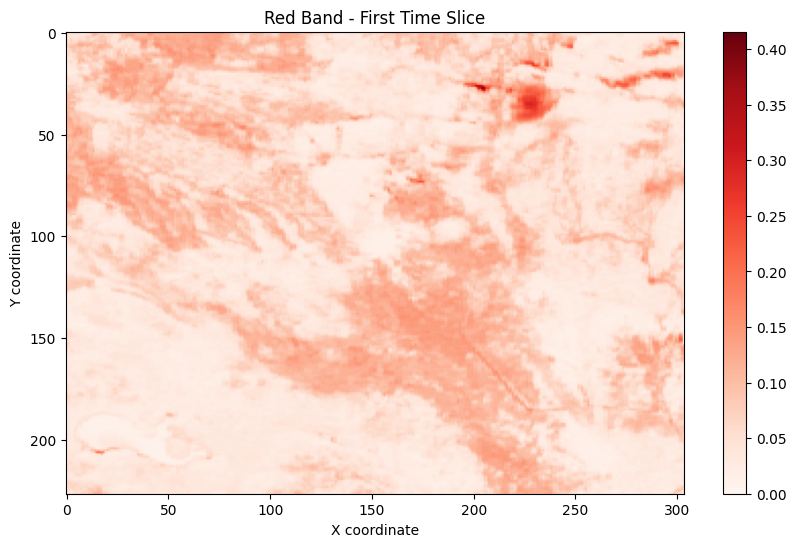

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.imshow(data_cube['S2_RED'].isel(time=0), cmap='Reds')
plt.colorbar()
plt.title('Red Band - First Time Slice')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()


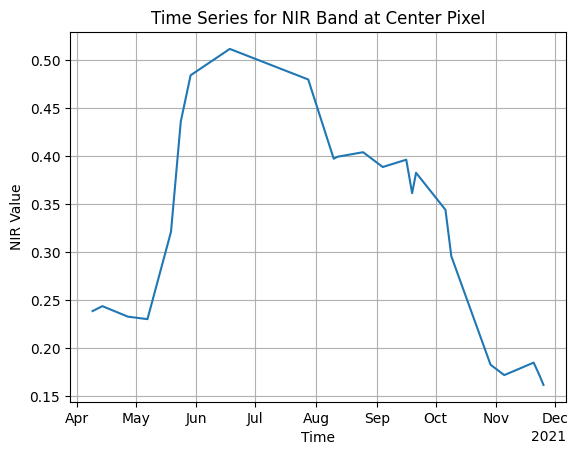

In [4]:
pixel_time_series = data_cube['S2_NIR'].isel(x=int(data_cube['x'].size / 2), y=int(data_cube['y'].size / 2))
pixel_time_series.plot()
plt.title('Time Series for NIR Band at Center Pixel')
plt.xlabel('Time')
plt.ylabel('NIR Value')
plt.grid(True)
plt.show()

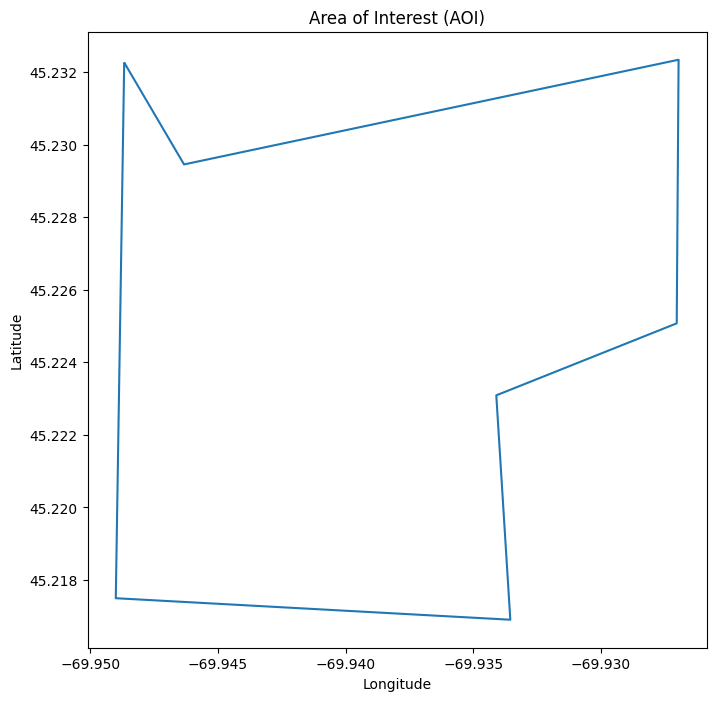

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))
aoi.boundary.plot(ax=ax)
ax.set_title('Area of Interest (AOI)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [6]:
import folium

m = folium.Map(location=[45.23, -69.94], zoom_start=14, tiles='Esri.WorldImagery')

folium.GeoJson(aoi, name='geojson').add_to(m)
folium.LayerControl().add_to(m)

m.save('AOI_map.html')
m

In [7]:
m2 = folium.Map(location=[45.23, -69.94], zoom_start=14, tiles='OpenTopoMap')

folium.GeoJson(aoi, name='geojson').add_to(m2)
folium.LayerControl().add_to(m)

m2.save('AOI_map.html')
m2

From the coordinates we can see that our AOI is in Maine, United States.
We can see significant elevation changes, with some areas marked by tight contour intervals, indicating steep slopes. This can lead to microclimates within the AOI, affecting local weather patterns, vegetation types, and biodiversity.

The images shows a mix of forested areas and open spaces.

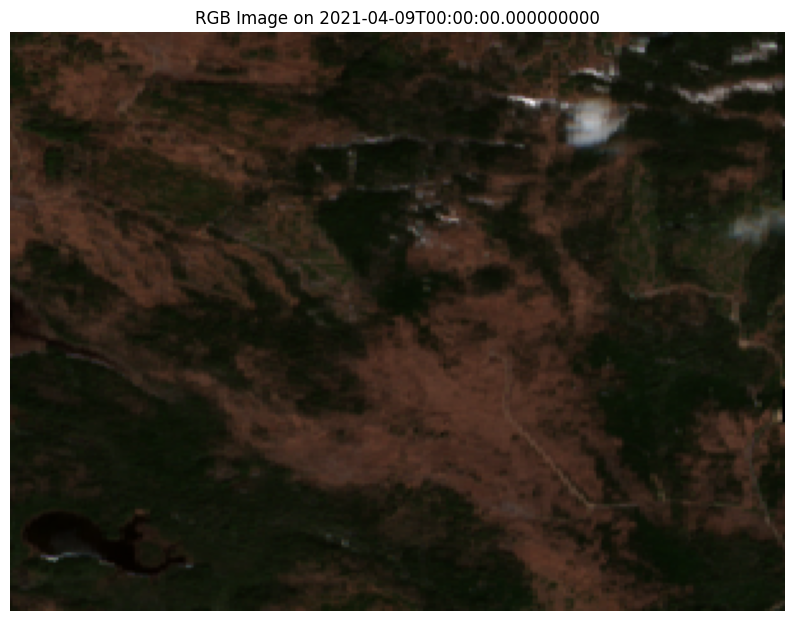

In [8]:
import numpy as np

date_index = 0

# Extract the RGB layers for that date
red = data_cube['S2_RED'].isel(time=date_index)
green = data_cube['S2_GREEN'].isel(time=date_index)
blue = data_cube['S2_BLUE'].isel(time=date_index)

# Stack the bands along a new third dimension to form an RGB image
rgb = np.stack([red, green, blue], axis=-1)

# Normalize the data for display
rgb_normalized = (rgb - rgb.min()) / (rgb.max() - rgb.min())

# Plot the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_normalized)
plt.title('RGB Image on ' + str(data_cube['time'].values[date_index]))
plt.axis('off')
plt.show()

Normalized Difference Vegetation Index (NDVI) is calculated using the formula NDVI=(NIR+Red)/(NIR−Red), where NIR is the near-infrared bar and Red is the Red band.

In [11]:
data_cube['NDVI'] = (data_cube['S2_NIR'] - data_cube['S2_RED']) / (data_cube['S2_NIR'] + data_cube['S2_RED'])

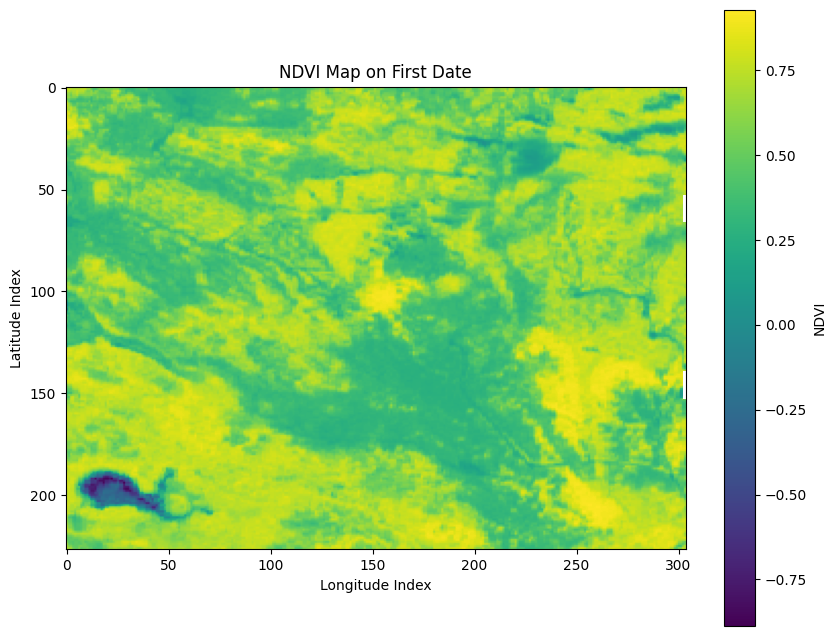

In [12]:
ndvi_snapshot = data_cube['NDVI'].isel(time=0)

# Plot NDVI map
plt.figure(figsize=(10, 8))
plt.imshow(ndvi_snapshot, cmap='viridis')
plt.colorbar(label='NDVI')
plt.title('NDVI Map on First Date')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.show()

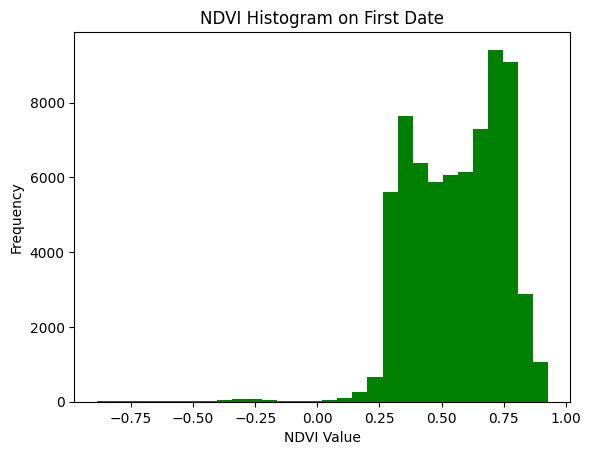

In [13]:
ndvi_values = data_cube['NDVI'].isel(time=0).values.flatten()

plt.hist(ndvi_values, bins=30, color='green')
plt.title('NDVI Histogram on First Date')
plt.xlabel('NDVI Value')
plt.ylabel('Frequency')
plt.show()

We can see that at the first date, i.e. around the start/mid April, most of the NDVI values are positive, which generally suggests that the area has a significant amount of vegetation.

There are very few negative values, which implies minimal presence of water bodies or bare ground in this snapshot.

This is the situation when the data was first gathered. Now we will look at a time series visualization of the data to understand how the vegetation evolved through time.

### Time Series of NDVI Averaged Over the AOI

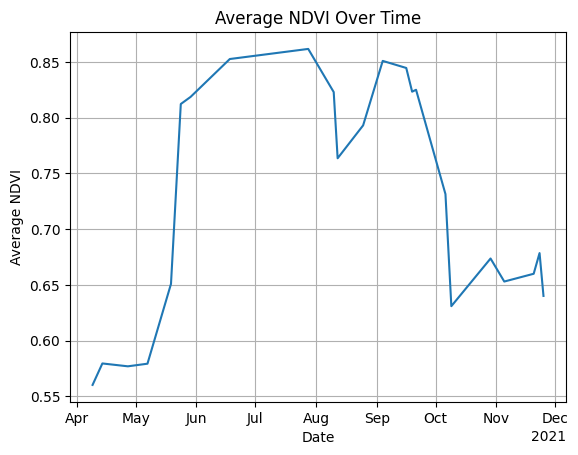

In [14]:
mean_ndvi = data_cube['NDVI'].mean(dim=['x', 'y'])

# Plotting the time series
mean_ndvi.plot()
plt.title('Average NDVI Over Time')
plt.xlabel('Date')
plt.ylabel('Average NDVI')
plt.grid(True)
plt.show()

In [19]:
import matplotlib.animation as animation

fig, ax = plt.subplots()

im = ax.imshow(data_cube['NDVI'].isel(time=0), cmap='viridis', vmin=-1, vmax=1)
plt.colorbar(im, ax=ax)
ax.set_title('NDVI Animation')

def update(frame):
    ax.clear()
    im = ax.imshow(data_cube['NDVI'].isel(time=frame), cmap='viridis')
    ax.set_title(f"NDVI on {data_cube['time'].values[frame]}")
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(data_cube['time']), blit=True)

from IPython.display import HTML
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>